In [1]:
import pandas as pd
import numpy as np

# Load the data located in /Dataset_creation/df_AD.csv
df_AD = pd.read_pickle('Dataset_creation/df_AD.pkl')
# Could be used to remove AttributeError: 'bool' object has no attribute 'any'
# df_AD.replace(to_replace=pd.NA, value=None, inplace=True)
# Reset the index
df_AD = df_AD.reset_index(drop=True)

# df_AD

In [2]:
import sklearn

print(sklearn.__version__)

1.2.2


In [3]:
columns_to_keep = ['ESO INS4 FILT3 NAME', 'ESO INS4 OPTI22 NAME', \
    'ESO AOS VISWFS MODE', 'ESO TEL AMBI WINDSP', 'SCFOVROT', 'SC MODE', 'ESO TEL AMBI RHUM', \
        'HIERARCH ESO INS4 TEMP422 VAL', 'HIERARCH ESO TEL TH M1 TEMP', 'HIERARCH ESO TEL AMBI TEMP', \
            'ESO DET NDIT', 'ESO DET SEQ1 DIT', 'SIMBAD_FLUX_G', 'SIMBAD_FLUX_H', 'SEEING_MEDIAN', \
                'SEEING_STD', 'COHERENCE_TIME_MEDIAN', 'COHERENCE_TIME_STD', 'SEPARATION', 'NSIGMA_CONTRAST']

                # 'EFF_NFRA', 'EFF_ETIM', 'SR_AVG' are not included due to the high number of NaN values

# Get a dataframe containing only the columns we want to keep
df_AD = df_AD[columns_to_keep]

# Convert the strings to numbers in order to transform it into a tensor
df_AD['ESO INS4 FILT3 NAME'] = pd.factorize(df_AD['ESO INS4 FILT3 NAME'])[0]
df_AD['ESO INS4 OPTI22 NAME'] = pd.factorize(df_AD['ESO INS4 OPTI22 NAME'])[0]
df_AD['ESO AOS VISWFS MODE'] = pd.factorize(df_AD['ESO AOS VISWFS MODE'])[0]
df_AD['SC MODE'] = pd.factorize(df_AD['SC MODE'])[0]

# Convert the columns 'SEPARATION' and 'NSIGMA_CONTRAST' to numpy arrays
separation = np.array(df_AD['SEPARATION'])
nsigma_contrast = np.array(df_AD['NSIGMA_CONTRAST'])

df_AD.dtypes


ESO INS4 FILT3 NAME                int64
ESO INS4 OPTI22 NAME               int64
ESO AOS VISWFS MODE                int64
ESO TEL AMBI WINDSP              float64
SCFOVROT                         float64
SC MODE                            int64
ESO TEL AMBI RHUM                float64
HIERARCH ESO INS4 TEMP422 VAL    float64
HIERARCH ESO TEL TH M1 TEMP      float64
HIERARCH ESO TEL AMBI TEMP       float64
ESO DET NDIT                       int64
ESO DET SEQ1 DIT                 float64
SIMBAD_FLUX_G                    float64
SIMBAD_FLUX_H                    float64
SEEING_MEDIAN                    float64
SEEING_STD                       float64
COHERENCE_TIME_MEDIAN            float64
COHERENCE_TIME_STD               float64
SEPARATION                        object
NSIGMA_CONTRAST                   object
dtype: object

In [4]:
import webbrowser

with open('table.html', 'w') as f:
    # f.write(tabulate(test_df, headers='keys', tablefmt='html'))
    f.write(df_AD.drop(['SEPARATION', 'NSIGMA_CONTRAST'], axis=1).to_html())

webbrowser.open('table.html')

True

# Random Forest Regression

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

x = df_AD.drop(['SEPARATION', 'NSIGMA_CONTRAST'], axis=1).values
print("x shape : {}".format(x.shape))
# Transform the NaN values into the median of the column
imp = SimpleImputer(strategy='median')
x = imp.fit_transform(x)

# Check whether there are still NaN, pd.NA or None values 
print("X contains NaN : {}".format(np.isnan(x).any()))
print("X contains pd.NA : {}".format(pd.isna(x).any()))
print("X contains None : {}".format(None in x))

y = np.array(df_AD['NSIGMA_CONTRAST'].tolist())
print("y shape : {}".format(y.shape))
print("y data type : {}".format(y.dtype))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print("Learning set size : {}, test set size : {}".format(len(x_train), len(x_test)))

x shape : (188, 18)
X contains NaN : False
X contains pd.NA : False
X contains None : False
y shape : (188, 124)
y data type : float64
Learning set size : 150, test set size : 38


In [13]:
# Define the search grid for hyperparameters
param_grid = {
    'n_estimators': [100, 500, 1000, 5000],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# Define the model
rf_regressor = RandomForestRegressor(random_state=42)

In [14]:
# Perform a grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

In [15]:
# Print the best hyperparameters
print("Best hyperparameters : {}".format(best_params))

Best hyperparameters : {'max_depth': 5, 'max_features': None, 'min_samples_split': 10, 'n_estimators': 100}


In [10]:
# Create a new random forest regressor with the best hyperparameters
rf_regressor = RandomForestRegressor(**best_params, random_state=42)

# Fit the model to the training data
rf_regressor.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_split=10, random_state=42)

In [11]:
# Use the model to make predictions on the test data
y_pred = rf_regressor.predict(x_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print("Mean Squared Error: {:.2f}".format(mse))
print("R-squared Score: {:.2f}".format(r2))

Mean Squared Error: 2.06
R-squared Score: -3.88


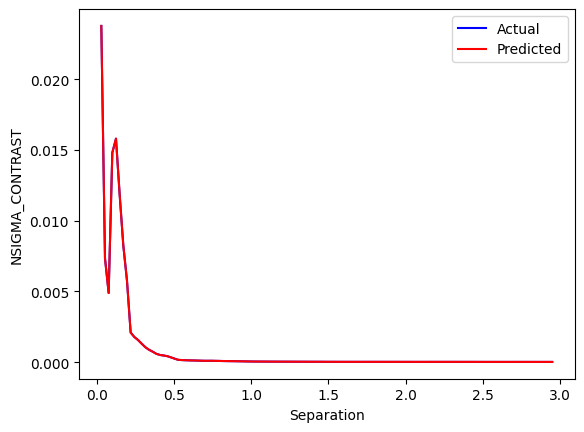

In [23]:
# Plot the predicted values vs the ctual ones for one observation
import matplotlib.pyplot as plt

x_plot = df_AD['SEPARATION'].iloc[0]
y_plot = y_pred[20]
y_pred_plot = y_pred[30]

plt.plot(x_plot, y_plot, color='blue', label='Actual')
plt.plot(x_plot, y_pred_plot, color='red', label='Predicted')
plt.xlabel('Separation')
plt.ylabel('NSIGMA_CONTRAST')
plt.legend()
plt.show()
